# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, VarianceThreshold, SelectKBest, SelectPercentile, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score


# Custom functions

In [2]:
#calculate adjusted r2
def m_adjusted_r2(obs_num, var_num,r2):
    return (1-(1-r2)*((obs_num-1)/(obs_num-var_num-1)))

#show features regression in Dataframe
def m_fregression(x,y):
    features_regression = pd.DataFrame(columns=['feature','coefficient','pval'])
    for i in range (x.shape[1]):
        df_f_regression = f_regression(x,y)
        row = {'feature':x.columns[i],'coefficient':df_f_regression[0][i].round(2),'pval':df_f_regression[1][i].round(5)}
        features_regression = features_regression.append(row,ignore_index=True)
    return (features_regression)

#calculating multicolinearity between variables
def m_VIF(x,y):
    #get columns names
    a = x.columns
    b = y.columns
    
    #loop to generate a (specially-formated) string containing (dependant variable) and (independent variables)
    string_fun = '{}~'.format(b[0])
    for i in range(0,len(a),1):
        string_fun = string_fun+"{}+".format(a[i])
        
    #to drop the last (+)
    string_fun= string_fun[0:len(string_fun)-1]
    string_fun
    
    #generate a full dataframe containing dependent and independent variables
    df_vif_gen = pd.merge(left=y,right=x,left_index=True,right_index=True)
    
    
    #find design matrix for regression model using 'rating' as response variable 
    y,x = dmatrices(string_fun, data=df_vif_gen, return_type='dataframe')

    #create DataFrame to hold VIF values
    vif_df = pd.DataFrame()
    vif_df['variable'] = x.columns 

    #calculate VIF for each predictor variable 
    vif_df['VIF'] = np.round([variance_inflation_factor(x.values, i) for i in range(x.shape[1])],2)

    #view VIF for each predictor variable 
    print ('VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.\n')
    print ('VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.\n')
    print ('VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.')

    return vif_df

# find correlated features
def m_correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.append(colname)
    return col_corr

#reduce dataframe by quantile value (outlier), return the reduced dataframe and print the curve
def m_df_trim (dataframe,column_name,q_low,q_high):   
    q_low = dataframe[column_name].quantile(q=q_low)
    q_high = dataframe[column_name].quantile(q=q_high)

    df_reduced = dataframe[(dataframe[column_name]>q_low)&(dataframe[column_name]<=q_high)]
    print (np.round(100-df_reduced.shape[0]/dataframe.shape[0]*100,2),"% of data will be lost")
    fig, ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2);
    sns.histplot(data=dataframe,x=column_name,ax=ax[0],label='Original');
    sns.histplot(data=df_reduced,x=column_name,ax=ax[1],label='Reduced')
    ax[0].legend()
    ax[1].legend()
    return df_reduced

#creating different linear regression models and a dataframe containing the summary info
def m_mlinear_regression(xtr,xts,ytr,yts):
#create a dataframe for modeling summary 
    models_summary = pd.DataFrame(columns=['Model','Type','Scaled','Score'])

    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Linear'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='SVR'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr,ytr)
        ypr = model.predict(xts)
        #
        model_name='Random forest'
        model_type=i
        scaled='No'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr,ytr)
    ypr = model.predict(xts)
    #
    model_name='XGBoost'
    scaled='No'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
#---------------SCALING-------------------#
    sc    = StandardScaler()              #
    xtr_sc= sc.fit_transform(xtr)         #
    xts_sc= sc.transform(xts)             #
#-----------------------------------------#
    #multiple linear regression
    model = LinearRegression()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Linear'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    
    #support vector regression
    model_variables=['rbf','linear','poly','sigmoid']
    for i in model_variables:
        model = SVR(kernel=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='SVR'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Decision treeregression
    model = DecisionTreeRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='Decision tree'
    model_type='General'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #Random forest regression
    model_variables = [100,200,300,400,500]
    for i in model_variables:
        model = RandomForestRegressor(n_estimators=i)
        model.fit(xtr_sc,ytr)
        ypr = model.predict(xts_sc)
        #
        model_name='Random forest'
        model_type=i
        scaled='Yes'
        score = r2_score(yts,ypr)
        #plt.scatter(yts,ypr);
        #plt.plot(yts,ypr,color='r');
        models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)

    #XGBoost
    model = XGBRegressor()
    model.fit(xtr_sc,ytr)
    ypr = model.predict(xts_sc)
    #
    model_name='XGBoost'
    scaled='Yes'
    score = r2_score(yts,ypr)
    #plt.scatter(yts,ypr);
    #plt.plot(yts,ypr,color='r');
    models_summary = models_summary.append({'Model':model_name,'Type':model_type,'Scaled':scaled,'Score':score},ignore_index=True)


    model_summary = models_summary.sort_values(by='Score',ascending=False)
    model_summary.reset_index(inplace=True)
    return model_summary

#return a list and graph of how features importance to target value
def m_feature_importance (xtrain,ytrain,n_estimators):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(xtrain,ytrain)
    df_features_importance = pd.DataFrame({'features':xtrain.columns,'importance':rf.feature_importances_})
    df_features_importance.sort_values(by='importance',axis=0,inplace=True,ascending=False)
    sns.barplot(x=df_features_importance['importance'],
                y=df_features_importance['features'],
                color='b')  
    return df_features_importance

# Importing data

In [3]:
df_raw = pd.read_csv('boston.csv')

In [4]:
df_raw.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


**Input features in order:**
1) CRIM: per capita crime rate by town. <br>
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.<br>
3) INDUS: proportion of non-retail business acres per town<br>
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)<br>
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]<br>
6) RM: average number of rooms per dwelling<br>
7) AGE: proportion of owner-occupied units built prior to 1940<br>
8) DIS: weighted distances to five Boston employment centres<br>
9) RAD: index of accessibility to radial highways<br>
10) TAX: full-value property-tax rate per $10,000 [$/10k]<br>
11) PTRATIO: pupil-teacher ratio by town<br>
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town<br>
13) LSTAT: % lower status of the population<br>

**Output variable:**
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

**Problem Description:**<br>
model the value of owner occupied homes related to different features.

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
df_raw.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [7]:
df = df_raw.copy()
col_raw= list(df.columns)

# Data cleaning

There are no null values to be cleaned

# Exploratory data analysis

In [8]:
#changing the target variable column [MEDV] to be the first column
col_raw_ordered = ['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT']
df = df[col_raw_ordered]

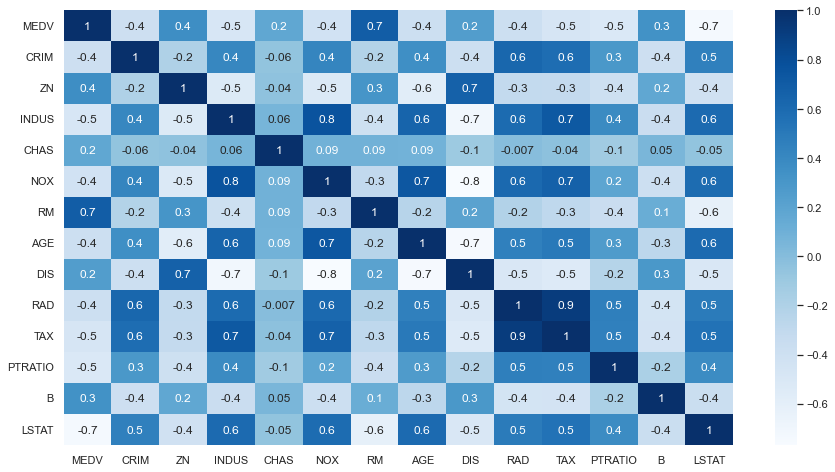

In [9]:
#let's check for correlation between all features
fig,ax = plt.subplots(figsize=(15,8))
sns.heatmap(df.corr(),cmap='Blues',annot=True,fmt='.1g',);

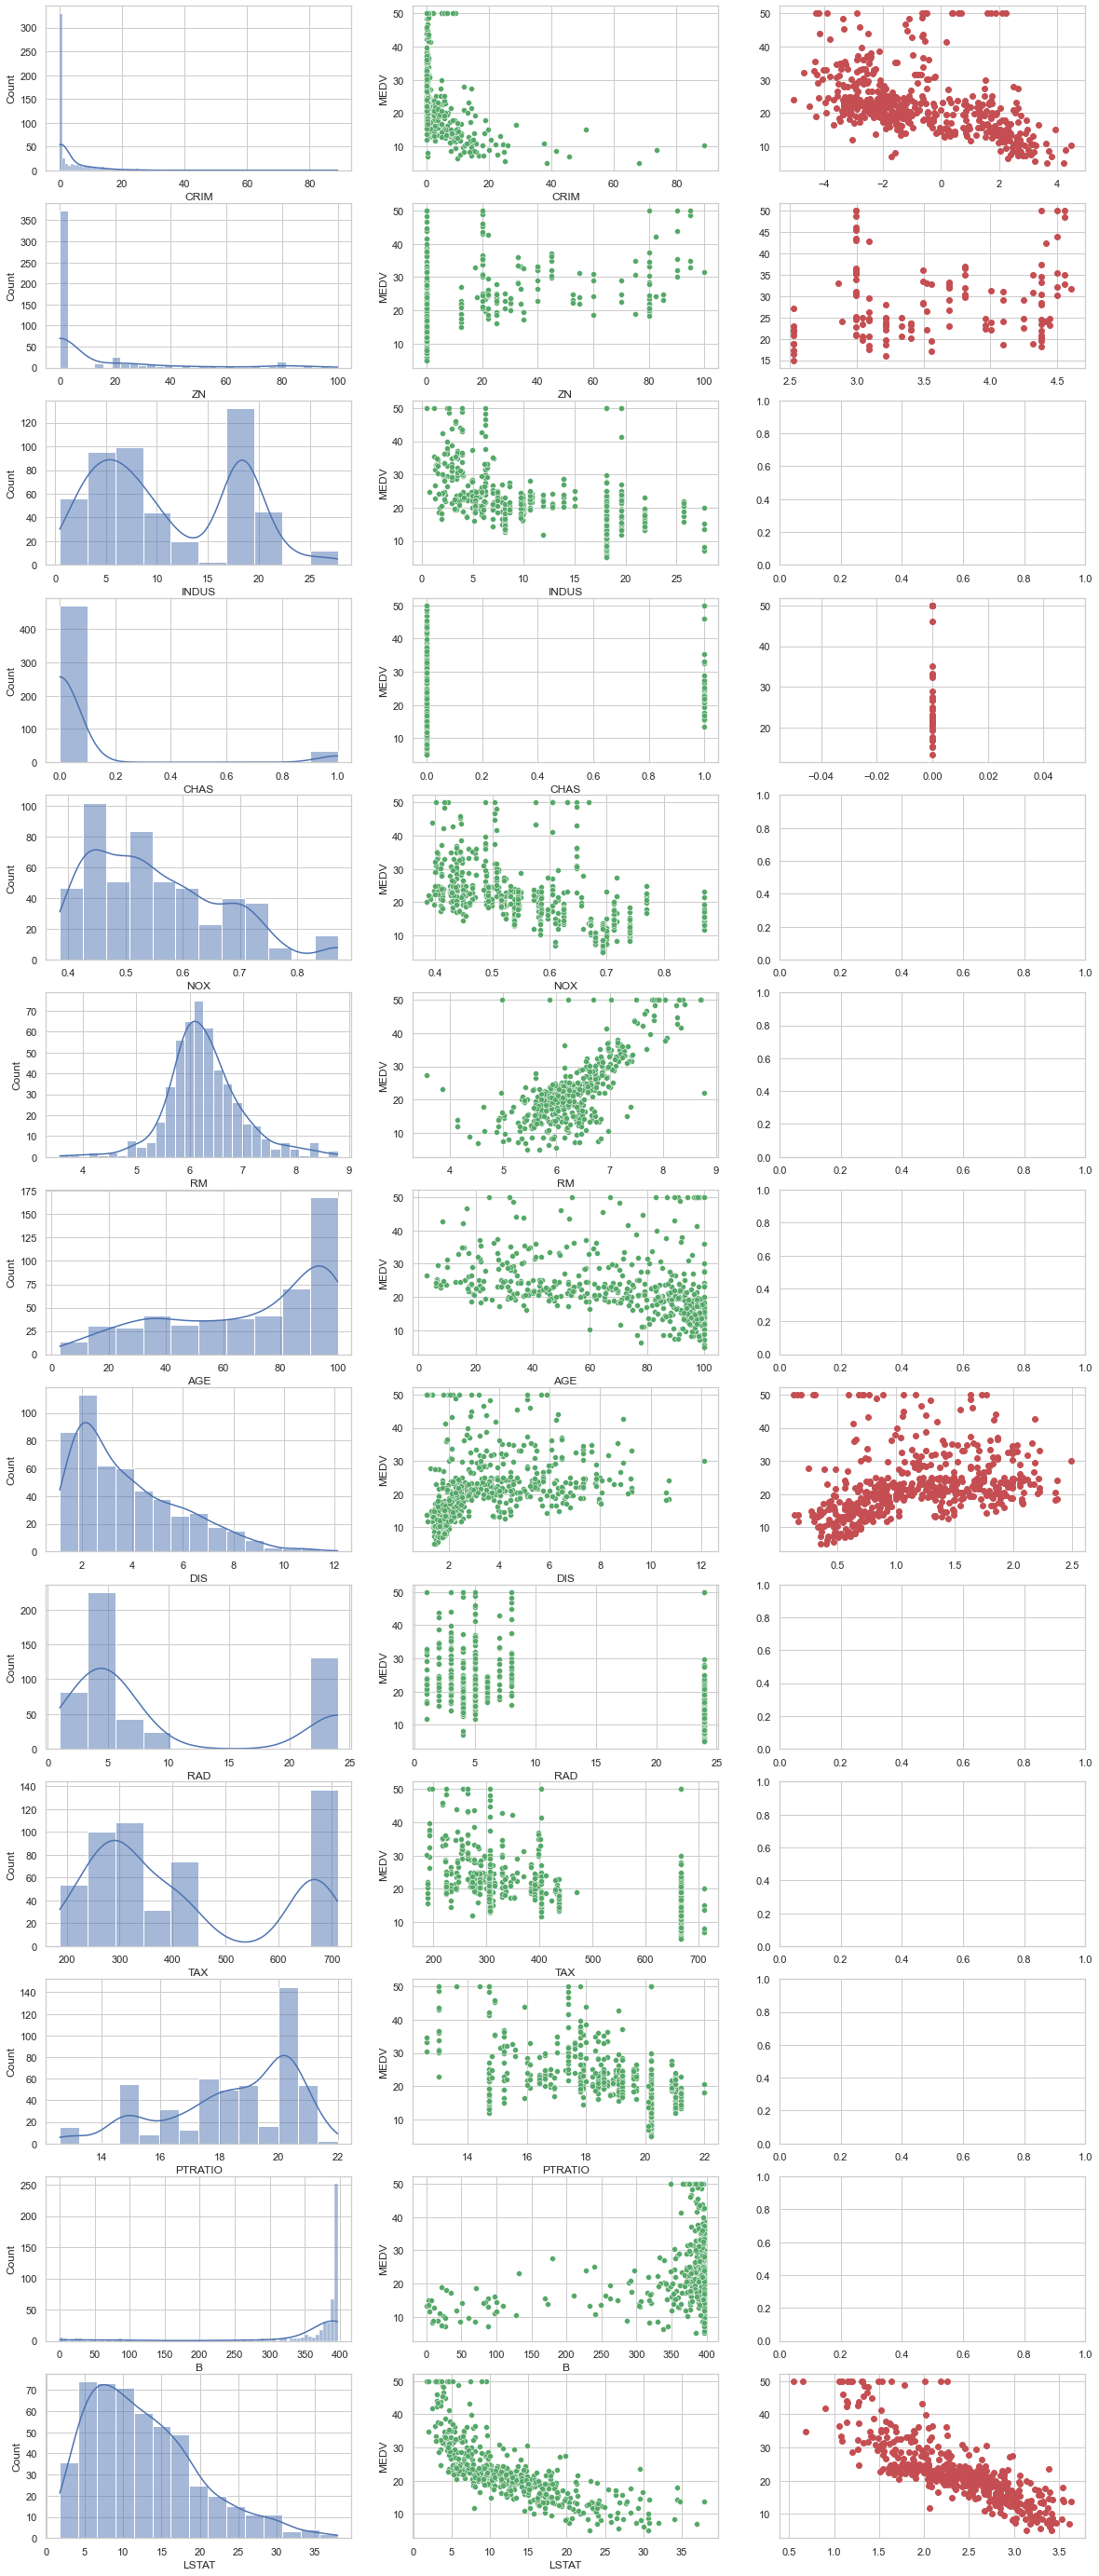

In [10]:
#visualizing and transforming features against dependent variable
fig,ax = plt.subplots(nrows=(len(col_raw_ordered)-1),ncols=3,figsize=(20,50));
for i in range (1,len(col_raw_ordered),1):
    sns.histplot(data=df.iloc[:,i],kde=True,ax=ax[i-1,0])
    sns.scatterplot(data=df,x=col_raw_ordered[i],y=col_raw_ordered[0],ax=ax[i-1,1],color='g');

#drawing the final features transformations
ax[0,2].scatter(np.log(df['CRIM']),df['MEDV'],color='r');
ax[1,2].scatter(np.log(df['ZN']),df['MEDV'],color='r');
ax[3,2].scatter(np.log(df['CHAS']),df['MEDV'],color='r');
ax[7,2].scatter(np.log(df['DIS']),df['MEDV'],color='r');
ax[12,2].scatter(np.log(df['LSTAT']),df['MEDV'],color='r');

**some elemantry insights:**
1) CRIM: skewed to right, there may be outliers <br>
2) ZN: skewed to right, there may be outliers<br>
3) CHAS: most of the unites are away from CHAS river<br>
4) NOX: little skewed to right, negative proportion to MEDV<br>
5) RM: uniformly distributed, it has positive proportion to MEDV<br>
6) AGE: skewed to left, it has almost constat value against MEDV<br>
7) DIS: skewed to right, it may has outliers<br>
8) RAD:<br>
9) TAX:<br> 
10) PTRATIO:<br>
11) B: is very skewed to right, it sure contains outliers<br>
12) LSTAT: may be skewed to right, and it has negative proportion to MEDV<br>

**Also,** <br>
CRIM: -ve corr with log<br>
IDUS: -ve corr<br>
CHAS: most of them are 0 <br>
NOX : -ve corr<br>
RM  : +ve corr<br>
DIS : +ve corr with log<br>
LSTAT: -ve corr with log<br>

# Machine learning

## Modeling raw data

In [11]:
y_raw = df[col_raw_ordered[0:1]]
x_raw = df[col_raw_ordered[1:]]

In [12]:
x_raw_tr,x_raw_ts, y_raw_tr,y_raw_ts = train_test_split(x_raw,y_raw,train_size=0.9)

In [13]:
m_mlinear_regression(x_raw_tr,x_raw_ts,y_raw_tr,y_raw_ts)

,index,Model,Type,Scaled,Score
0,20,Random forest,300,Yes,0.936056
1,19,Random forest,200,Yes,0.935935
2,6,Random forest,100,No,0.933904
3,18,Random forest,100,Yes,0.933256
4,22,Random forest,500,Yes,0.932775
5,8,Random forest,300,No,0.932706
6,21,Random forest,400,Yes,0.929068
7,7,Random forest,200,No,0.928026
8,9,Random forest,400,No,0.926437
9,10,Random forest,500,No,0.924253


without any feature engineering, (XGBoost and Random forest) model have an accuracy > 80%, let's see if I can improve the model by doing feature engineering

## Feature engineering

### Filtering

#### Constant / Quasi constant features

In [14]:
#checking constant variables
selector_const = VarianceThreshold(threshold=0.0)
selector_const.fit(x_raw_tr)

VarianceThreshold()

In [15]:
selector_const.get_support().sum(), x_raw_tr.shape[1]

(13, 13)

There are no constant features

In [16]:
#checking quasi constant variables
selector_quasi = VarianceThreshold(threshold=0.01)
selector_quasi.fit(x_raw_tr)

VarianceThreshold(threshold=0.01)

In [17]:
selector_quasi.get_support().sum(), x_raw_tr.shape[1]

(13, 13)

There are no semi constant features

In [18]:
#creating features and variance list
features_variance = {'feature':list(x_raw_tr.columns),'feature_variance':list(selector_quasi.get_support())}
df_features_variance = pd.DataFrame(features_variance)
df_features_variance[(df_features_variance['feature_variance']==False)]

,feature,feature_variance


#### Correlation

In [19]:
m_correlation(x_raw_tr,0.8)

['TAX']

In [20]:
m_VIF(x_raw_tr,y_raw_tr)

VIF=1: There is no correlation between a given predictor variable and any other predictor variables in the model.

VIF=(1-5): There is moderate correlation between a given predictor variable and other predictor variables in the model.

VIF>5: There is severe correlation between a given predictor variable and other predictor variables in the model.


,variable,VIF
0,Intercept,593.67
1,CRIM,1.75
2,ZN,2.30
3,INDUS,4.25
4,CHAS,1.10
5,NOX,4.65
6,RM,1.94
7,AGE,3.13
8,DIS,3.89
9,RAD,7.31


it seems that [TAX and RAD] are heavily correlated with each others, it's important to drop any feature from dataframe

#### Feature importance

,features,importance
12,LSTAT,0.452184
5,RM,0.355335
7,DIS,0.055542
0,CRIM,0.040913
4,NOX,0.021212
9,TAX,0.018411
10,PTRATIO,0.015577
6,AGE,0.012950
11,B,0.011491
2,INDUS,0.007734


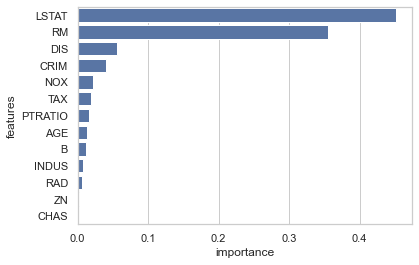

In [21]:
m_feature_importance(x_raw_tr,y_raw_tr,100)

it's obvious that features [RM, LSTAT] are very important in predicting target value

In [22]:
#i will add the transformed columns to dataframe
df['CRIM_log'] = np.log(df['CRIM'])
df['DIS_log'] = np.log(df['DIS'])
df['LSTAT_log'] = np.log(df['LSTAT'])

In [23]:
col_new=list(df.columns)

In [24]:
y_new = df[col_new[0:1]]
x_new = df[col_new[1:]]

In [25]:
x_new_tr,x_new_ts,y_new_tr,y_new_ts = train_test_split(x_new,y_new,train_size=0.9)

,features,importance
5,RM,0.444918
15,LSTAT_log,0.173954
12,LSTAT,0.172712
7,DIS,0.044305
14,DIS_log,0.038985
13,CRIM_log,0.021584
4,NOX,0.020691
0,CRIM,0.019981
10,PTRATIO,0.015647
6,AGE,0.012631


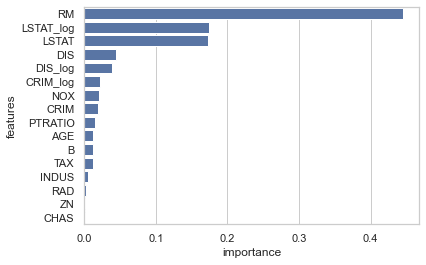

In [26]:
m_feature_importance(x_new_tr,y_new_tr,100)

#### Dimensionality reduction

In [27]:
#i tried with differet n_components but it didn't improve my model
pca =PCA(n_components=9).fit(x_raw_tr)
x_pca_tr=pca.transform(x_raw_tr)
x_pca_ts=pca.transform(x_raw_ts)
m_mlinear_regression(x_pca_tr,x_pca_ts,y_raw_tr,y_raw_ts)

,index,Model,Type,Scaled,Score
0,23,XGBoost,500,Yes,0.830461
1,11,XGBoost,500,No,0.830461
2,7,Random forest,200,No,0.826545
3,18,Random forest,100,Yes,0.822754
4,21,Random forest,400,Yes,0.820298
5,9,Random forest,400,No,0.819480
6,22,Random forest,500,Yes,0.817891
7,20,Random forest,300,Yes,0.811184
8,19,Random forest,200,Yes,0.808602
9,8,Random forest,300,No,0.808498


## Processed data modeling

In [28]:
#removing TAX and RAD columns
col_no_tax = col_raw_ordered.copy()
col_no_tax.remove('TAX')
col_no_tax.remove('RAD')

In [29]:
y= df[col_no_tax[0:1]]
x= df[col_no_tax[1:]]

In [30]:
#no tax columns
xtr, xts, ytr, yts = train_test_split(x,y,train_size=0.9)

In [31]:
m_mlinear_regression(xtr,xts,ytr,yts)

,index,Model,Type,Scaled,Score
0,5,Decision tree,General,No,0.783374
1,18,Random forest,100,Yes,0.770174
2,20,Random forest,300,Yes,0.768290
3,8,Random forest,300,No,0.764649
4,19,Random forest,200,Yes,0.763942
5,10,Random forest,500,No,0.761162
6,21,Random forest,400,Yes,0.760803
7,7,Random forest,200,No,0.760742
8,22,Random forest,500,Yes,0.760124
9,9,Random forest,400,No,0.754339


## Evaluation models

### K fold with random forest

In [36]:
sc = StandardScaler()
xtr_sc = sc.fit_transform(xtr)
xts_sc = sc.transform(xts)

In [37]:
model_1 = RandomForestRegressor(n_estimators=100)
model_2 = XGBRegressor()

In [38]:
cv = cross_val_score(estimator=model_1,X=xtr_sc,y=ytr,cv=10)

In [39]:
cv.mean(),cv.std(),cv.max()

(0.8683302476486414, 0.03799285671036878, 0.9158264159120139)

## Optimizing hyperparameters

optimizing parameters of random forest

In [40]:
parameters = {'n_estimators':[100,200,300]}
gsearch = GridSearchCV(estimator=model_1,param_grid=parameters)

In [41]:
gsearch.fit(xtr_sc,ytr).best_params_

{'n_estimators': 300}

our best model so far is random forest with n_estimators=100